In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/dataset/MVSA-multiple.zip'
extract_path = '/content/dataset'

# Create the extraction directory
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['MVSA']

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch

# Load necessary resources for text processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Load data
label_results_path = os.path.join(extract_path, 'MVSA/labelResultAll.txt')
data_folder_path = os.path.join(extract_path, 'MVSA/data')
label_results = pd.read_csv(label_results_path, delimiter='\t', header=None, names=['ID', 'annotation1', 'annotation2', 'annotation3'])

# Split annotations and get majority sentiment
def safe_split(annotation):
    parts = annotation.split(',')
    return parts if len(parts) == 2 else ['unknown', 'unknown']

for i in range(3):
    label_results[[f'text_sentiment_{i+1}', f'image_sentiment_{i+1}']] = label_results[f'annotation{i+1}'].apply(safe_split).apply(pd.Series)
label_results.drop(columns=[f'annotation{i+1}' for i in range(3)], inplace=True)

from collections import Counter
def get_majority_sentiment(row):
    text_sentiments = row[[f'text_sentiment_{i+1}' for i in range(3)]]
    image_sentiments = row[[f'image_sentiment_{i+1}' for i in range(3)]]
    text_sentiment = Counter(text_sentiments).most_common(1)[0][0] if Counter(text_sentiments).most_common(1)[0][1] > 1 else 'unknown'
    image_sentiment = Counter(image_sentiments).most_common(1)[0][0] if Counter(image_sentiments).most_common(1)[0][1] > 1 else 'unknown'
    return pd.Series([text_sentiment, image_sentiment], index=['text_sentiment', 'image_sentiment'])

label_results[['text_sentiment', 'image_sentiment']] = label_results.apply(get_majority_sentiment, axis=1)
label_results = label_results[(label_results['text_sentiment'] != 'unknown') & (label_results['image_sentiment'] != 'unknown')]

# Load the image-text data
files = os.listdir(data_folder_path)
image_files = [f for f in files if f.endswith('.jpg')]
text_files = [f for f in files if f.endswith('.txt')]

# Function to read text file with different encodings
def read_text_file(file_path):
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            continue
    return None

data = {'ID': [], 'image_path': [], 'text': []}
for image_file in image_files:
    file_id = os.path.splitext(image_file)[0]
    text_file = file_id + '.txt'
    if text_file in text_files:
        text_content = read_text_file(os.path.join(data_folder_path, text_file))
        if text_content:
            data['ID'].append(file_id)
            data['image_path'].append(os.path.join(data_folder_path, image_file))
            data['text'].append(text_content)

df = pd.DataFrame(data)
df['ID'] = df['ID'].astype(str)
label_results['ID'] = label_results['ID'].astype(str)
df = pd.merge(df, label_results[['ID', 'text_sentiment', 'image_sentiment']], on='ID')

# Filter to keep only rows where text sentiment and image sentiment are the same
df = df[df['text_sentiment'] == df['image_sentiment']]

# Convert labels to numerical values
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['text_sentiment'] = df['text_sentiment'].map(label_mapping)
df['image_sentiment'] = df['image_sentiment'].map(label_mapping)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_text'].values)
sequences = tokenizer.texts_to_sequences(df['processed_text'].values)

# Define maximum length based on 95% coverage
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))
max_length_coverage = df['text_length'].quantile(0.95)
max_sequence_length = int(max_length_coverage)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode the sentiment labels for text data
y_text = tf.keras.utils.to_categorical(df['text_sentiment'], num_classes=3)

# Image preprocessing with advanced augmentations
img_height, img_width = 224, 224
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_data = np.array([load_and_preprocess_image(img_path)[0] for img_path in df['image_path']])

# Train-test split
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(padded_sequences, y_text, test_size=0.2, random_state=42, stratify=y_text)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(image_data, y_text, test_size=0.2, random_state=42, stratify=y_text)

# Adjust class weights
class_weights_dict = {
    0: 1.0 * 4.0,  # Increase weight for Negative class, moderate increase
    1: 0.98 * 1.5, # Moderate increase for Neutral class
    2: 1.0         # Keep Positive class weight as is
}

# Hyperparameter Tuning Model Definition
def build_densenet_model(hp):
    # CNN Model (Image)
    base_model = DenseNet121(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
    x = base_model.output

    # Applying additional convolutional and pooling layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Conv2D(hp.Int('filters', 32, 128, step=32), (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-4, 1e-3])))(x)
        if x.shape[1] > 2 and x.shape[2] > 2:  # Apply pooling only if the spatial dimensions are large enough
            x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-4, 1e-3])))(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = BatchNormalization()(x)
    final_output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

In [ ]:
# Initialize the tuner
tuner = RandomSearch(
    build_densenet_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/sentiment_analysis_model54/',
    project_name='densenet_model_tuning'
)

# Run the hyperparameter search with class weights
tuner.search(X_train_img, y_train_img, epochs=50, validation_split=0.2, class_weight=class_weights_dict, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Get the best hyperparameters and train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
densenet_model = tuner.hypermodel.build(best_hps)
history = densenet_model.fit(X_train_img, y_train_img, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weights_dict, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Save the best DenseNet model
densenet_model_save_path = '/content/drive/MyDrive/sentiment_analysis_model54/best_densenet_model.keras'
densenet_model.save(densenet_model_save_path)

# Evaluate the model
val_loss, val_accuracy = densenet_model.evaluate(X_val_img, y_val_img)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


In [ ]:
# Evaluate the DenseNet model
val_loss, val_accuracy = densenet_model.evaluate(X_val_img, y_val_img)

# Print the validation accuracy and loss
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate classification report and confusion matrix for the DenseNet model
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes
y_pred = densenet_model.predict(X_val_img)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true = np.argmax(y_val_img, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5939 - loss: 0.9167
Validation Loss: 0.9168
Validation Accuracy: 0.5817
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.44      0.39      0.41       882
           2       0.65      0.74      0.69      1517

    accuracy                           0.58      2520
   macro avg       0.36      0.38      0.37      2520
weighted avg       0.54      0.58      0.56      2520

Confusion Matrix:
 [[   0   46   75]
 [   0  345  537]
 [   0  396 1121]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


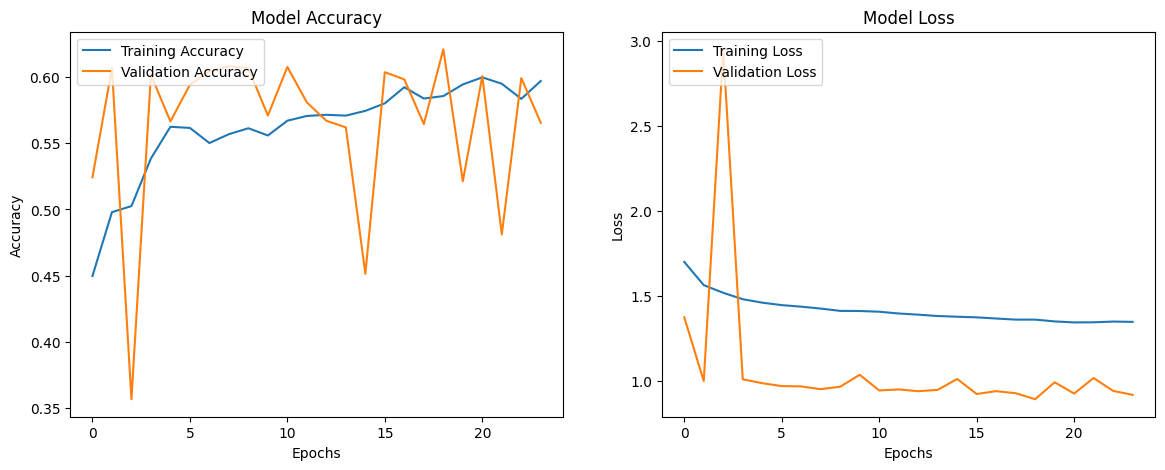

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Call the function to plot the metrics
plot_training_validation_metrics(history)
